In [ ]:
!pip install functorch
print("--> Restarting colab instance") 
get_ipython().kernel.do_shutdown(True)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |██████████████████████████████  | 834.1 MB 1.2 MB/s eta 0:00:46tcmalloc: large alloc 1147494400 bytes == 0x65c10000 @  0x7f94385f6615 0x5d631c 0x51e4f1 0x51e67b 0x4f7585 0x49ca7c 0x4fdff5 0x49caa1 0x4fdff5 0x49ced5 0x4f60a9 0x55f926 0x4f60a9 0x55f926 0x4f60a9 0x55f926 0x5d7c18 0x5d9412 0x586636 0x5d813c 0x55f3fd 0x55e571 0x5d7cf1 0x49ced5 0x55e571 0x5d7cf1 0x49ec69 0x5d7c18 0x49ca7c 0x4fdff5 0x49ced5
     |████████████████████████████████| 890.2 MB 5.2 kB/s 
     |████████████████████████████████| 557.1 MB 12 kB/s 
     |████████████████████████████████| 317.1 MB 35 kB/s 
     |████████████████████████████████| 21.0 MB 1.3 MB/s 
     |████████████████████████████████| 849 kB 61.3 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
ERROR: pip's dependency resolve

{'status': 'ok', 'restart': True}

In [ ]:
import matplotlib.pyplot as plt
import torch
from scipy.integrate import solve_ivp
from torch import nn
import numpy as np
%matplotlib inline

In [101]:
from functorch import vmap, vjp
from functorch import jacrev, jacfwd

# class NNApproximator(nn.Module):
#   def __init__(self, dim_input = 1, dim_output = 2, num_hidden = 2, dim_hidden = 1, activation=nn.Tanh()):
#     super().__init__()

#     self.layer_in = nn.Linear(dim_input, dim_hidden)
#     self.layer_out = nn.Linear(dim_hidden, dim_output)
#     # self.A = nn.Parameter(torch.randn(2,2))
#     self.k = nn.Parameter(torch.rand(1, requires_grad=True))
#     # self.A = self.k * torch.from_numpy(np.array([[-1,1],[1,-1]]))

#     num_middle = num_hidden - 1
#     self.middle_layers = nn.ModuleList(
#         [nn.Linear(dim_hidden, dim_hidden) for _ in range(num_middle)]
#     )
#     self.activation = activation

#   def forward(self, x):
#     out = self.activation(self.layer_in(x))
#     for layer in self.middle_layers:
#       out = self.activation(layer(out))
#     return self.layer_out(out)

#   # reference for implementing derivatives for batched inputs
#   # https://pytorch.org/functorch/stable/notebooks/jacobians_hessians.html
#   def jacobian(self, x):
#     jac = vmap(jacrev(self.forward))
#     return jac(x).squeeze()

In [218]:
class NNOracle(nn.Module):
  def __init__(self, dim_input = 6, dim_output = 2):
    super().__init__()

    self.k = 50.0
    self.g = torch.from_numpy(np.array([[0, -9.81]]))
    self.L0 = 5.0

  def forward(self, x):
    x1 = x[:2]
    x2 = x[2:4]
    x3 = x[4:]
    dx1 = x2 - x1
    dx2 = x3 - x2
    dx1_norm = torch.sqrt(torch.sum(dx1 ** 2))
    dx2_norm = torch.sqrt(torch.sum(dx2 ** 2))
    f1 = -self.k * (dx1_norm - self.L0) * (dx1 / dx1_norm)
    f2 = self.k * (dx2_norm - self.L0) * (dx2 / dx2_norm)
    return self.g + f1 + f2

  def jacobian(self, x):
    jac = vmap(jacrev(self.forward))
    return jac(x).squeeze()

In [219]:
def compute_data_loss(model, x_tr, y_tr):
  return 0.5 * torch.mean((model.forward(x_tr) - y_tr) ** 2)

def compute_PINN_loss(model, x, k):
    F_dot = model.jacobian(x)
    s1 = x[:, 0:2] - x[:, 2:4]
    s2 = x[:, 4:6] - x[:, 2:4]

    s1 /= torch.norm(s1, dim=1)[:, None]
    s2 /= torch.norm(s2, dim=1)[:, None]

    s1rot = s1 @ torch.from_numpy(np.array([[0, -1], [1, 0]]).T).float()
    s2rot = s2 @ torch.from_numpy(np.array([[0, -1], [1, 0]]).T).float()

    # f1_constr = torch.norm(torch.einsum('ijk,ik->ij', F_dot[:, :, 0:2], s1), dim=1) - k
    # f2_constr = torch.norm(torch.einsum('ijk,ik->ij', F_dot[:, :, 4:6], s2), dim=1) - k

    # f1_perp = torch.einsum('ijk,ik->ij', F_dot[:, :, 0:2], s1rot) / (torch.norm(s1, dim=1) ** 2)[:, None]
    # f2_perp = torch.einsum('ijk,ik->ij', F_dot[:, :, 4:6], s2rot) / (torch.norm(s2, dim=1) ** 2)[:, None]
    # f1_perp = torch.einsum("ij,ik->i", f1_perp, s1)
    # f2_perp = torch.einsum('ij,ik->i', f2_perp, s2)

    f1_ax = torch.einsum('ij, ijk, ik->i', s1, F_dot[:, :, 0:2], s1) - k
    f2_ax = torch.einsum('ij, ijk, ik->i', s2, F_dot[:, :, 4:6], s2) - k
    f1_perp = torch.einsum('ij, ijk, ik->i', s1, F_dot[:, :, 0:2], s1rot)
    f2_perp = torch.einsum('ij, ijk, ik->i', s2, F_dot[:, :, 4:6], s2rot)

    print(f1_ax)
    print(f2_ax)
    print(f1_perp)
    print(f2_perp)
    
    return (f1_ax ** 2).mean() + (f2_ax ** 2).mean() + (f1_perp ** 2).mean() + (f2_perp ** 2).mean()

In [220]:
model = NNOracle()

Nt = 20
x = torch.rand(Nt, 6, requires_grad=True)
# print(x)
# print(model.jacobian(x))
print(compute_PINN_loss(model, x, model.k))

tensor([ 2.2888e-05, -1.5259e-05, -1.0681e-04, -6.1035e-05, -7.6294e-06,
        -4.5776e-05,  1.1444e-05, -6.1035e-05,  2.6703e-05,  1.9073e-05,
        -3.0518e-05,  7.6294e-06, -1.9073e-05,  7.6294e-06,  1.1444e-05,
        -3.0518e-05,  1.5259e-05,  1.5259e-05, -1.1444e-05,  3.8147e-05],
       grad_fn=<SubBackward0>)
tensor([ 1.1444e-05, -1.5259e-05, -3.8147e-06, -7.6294e-06,  1.9073e-05,
         1.9073e-05, -9.9182e-05,  4.5776e-05,  0.0000e+00, -3.8147e-05,
         7.6294e-06, -7.6294e-06,  4.5776e-05,  4.5776e-05,  7.6294e-06,
        -7.6294e-06,  3.8147e-05,  1.1444e-04, -1.1444e-05,  3.4332e-05],
       grad_fn=<SubBackward0>)
tensor([ 3.8147e-06,  1.5259e-05,  1.9073e-06,  0.0000e+00, -2.8610e-06,
        -6.6757e-05,  3.8147e-06, -3.8147e-06,  1.1444e-05,  2.8610e-06,
         0.0000e+00, -8.5831e-06,  1.4305e-06,  9.5367e-06, -7.6294e-06,
         3.8147e-06,  2.3842e-06,  3.8147e-06,  3.8147e-06,  3.8147e-06],
       grad_fn=<ViewBackward0>)
tensor([-5.7220e-06,  0.000

In [214]:
# x = torch.from_numpy(np.array([[0,0, 2,0, 3,2]])).float().requires_grad_()
# x = torch.rand(size=(1,6), requires_grad=True)

F_dot = model.jacobian(x).detach()
F_dot_2 = F_dot[:,4:].detach()
# eigval, eigvec = torch.linalg.eig(F_dot_2)
# eigvec = eigvec / eigvec[0,1]
# print(eigval)
# print(eigvec)

s2 = x[:, 4:6] - x[:, 2:4]
s2 = s2 / torch.norm(s2,dim=1).detach()
print("This should be equal to k: ", s2 @ F_dot_2 @ s2.T - model.k)
print("This should be equal to k: ", s2.squeeze().reshape(2,1).T @ F_dot_2 @ s2.squeeze().reshape(2,1) - model.k)

s2rot = s2 @ torch.from_numpy(np.array([[0., -1.], [1., 0.]], dtype='float')).float().detach()
print(s2)
print("This should be zero...?", s2 @ F_dot_2 @ s2rot.T)
print("This should be zero...?", s2.squeeze().reshape(2,1).T @ F_dot_2 @ s2rot.squeeze().reshape(2,1))

# print(s2.squeeze())
# print(s2rot.squeeze())
# print(F_dot_2.squeeze())
print(s2@F_dot_2@s2.T - model.k)
print(s2@F_dot_2@s2rot.T)

RuntimeError: ignored

In [229]:
# "x0" is the state where the mass m3 creates zero force
x0 = torch.from_numpy(np.array([0.0,0.0, 2.0,0.0, 2.0 + model.L0, 0.0]))
N = 41

r_max = 10
xx, yy = np.meshgrid(np.linspace(0, r_max, N), np.linspace(-r_max, r_max, N))
plot_pts = np.c_[xx.ravel(), yy.ravel()]

x_inp = torch.zeros(size=(plot_pts.shape[0],6))
x_inp[:, :4] = x0[:4]
x_inp[:, 4:] = torch.from_numpy(plot_pts)
x_inp[0, :] = x0

Fs = vmap(model.forward)(x_inp).squeeze()
F0 = Fs[0, :]

dF = (Fs - F0).detach().numpy()
# x_inp.shape

(-0.5, 10.5, -11.0, 11.0)

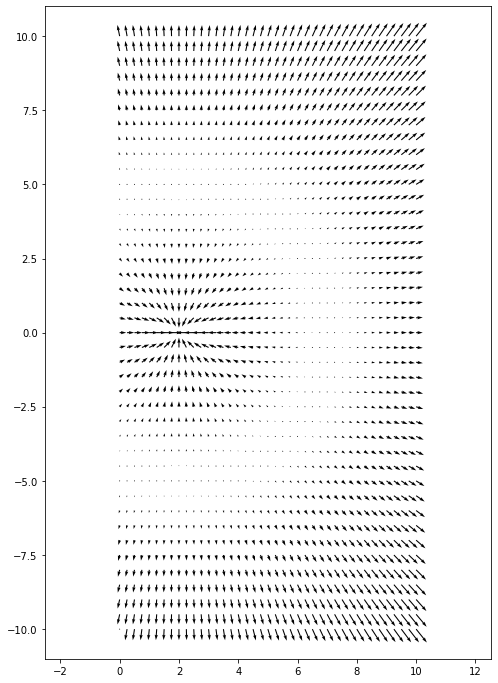

In [230]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,12))
ax.quiver(xx.ravel(), yy.ravel(), dF[:,0], dF[:,1])
ax.axis('equal')